# Predicting Bike Rentals

Many American cities have communal bike sharing stations where it's possible to rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

In this project, I'll try to predict the total number of bikes people rented in a given hour. To accomplish this, I'll create a few different machine learning models and evaluate their performance.

# Exploring the Data

[Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at the University of Porto compiled this data into a CSV file. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

Here's a preview of the data set:

In [32]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Options to set
%matplotlib inline
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 99)
np.random.seed(1)
model_seed = 1

# Load the data
bike_rentals = pd.read_csv("bike_rental_hour.csv")

bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Here are the descriptions for the relevant columns:

- `instant` - A unique sequential ID number for each row
- `dteday` - The date of the rentals
- `season` - The season in which the rentals occurred
- `yr` - The year the rentals occurred
- `mnth` - The month the rentals occurred
- `hr` - The hour the rentals occurred
- `holiday` - Whether or not the day was a holiday
- `weekday` - The day of the week (as a number, 0 to 7)
- `workingday` - Whether or not the day was a working day
- `weathersit` - The weather (as a categorical variable)
- `temp` - The temperature, on a 0-1 scale
- `atemp` - The adjusted temperature
- `hum` - The humidity, on a 0-1 scale
- `windspeed` - The wind speed, on a 0-1 scale
- `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- `registered` - The number of registered riders (people who had already signed up)
- `cnt` - The total number of bike rentals (`casual` + `registered`)

I'll predict the `cnt` column using all of the other columns, except for `casual` and `registered`.


## Histogram

Let's make a histogram of the `cnt` column of `bike_rentals`, and take a look at the distribution of total rentals.

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

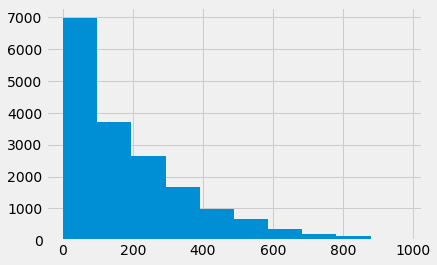

In [33]:
bike_rentals["cnt"].hist()
bike_rentals["cnt"].describe()

## Correlation

LEt's use the `corr()` method on the `bike_rentals` dataframe to explore how each column is correlated with `cnt`.

In [34]:
bike_rentals.corr()["cnt"].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

# Feature Engineering

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the `hr` column in `bike_rentals` contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. I can introduce some order into the process by creating a new column with labels for `morning`, `afternoon`, `evening`, and `night`. This will bundle similar times together, enabling the model to make better decisions.

In [0]:
def assign_label(hour):
    if hour < 6:
        return 4
    elif hour < 12:
        return 1
    elif hour < 18:
        return 2
    else:
        return 3

bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

Let's select the features that will be used for future models.

I'll need to ignore the `casual` and `registered` columns because `cnt` is derived from them.

In [0]:
features = list(bike_rentals.columns)
features.remove("cnt")
features.remove("casual")
features.remove("registered")
features.remove("dteday")

target = "cnt"

# Regression

Now I'm going to create different regressive models and compare them with RMSE based on 10-fold cross validation to have a more robust evaluation.

## Linear Regression

Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with `cnt`.

In general, linear regression works best when predictors are linearly correlated to the target and also independent. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

In [37]:
# Linear Regression
lr = LinearRegression()

# 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=model_seed)

# Calculate RMSE
rmse_lr = abs(np.mean(cross_val_score(estimator=lr, 
                                X=bike_rentals[features], 
                                  y=bike_rentals[target], 
                                  scoring="neg_root_mean_squared_error",
                                  cv=kf)))

print("RMSE: {:,.2f}".format(rmse_lr))

RMSE: 132.27


The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with RMSE, which leads to a higher total error.

## Decision Tree

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability, small changes in the input data can result in a very different output model.

In [38]:
# Decision Tree
dt = DecisionTreeRegressor(min_samples_leaf=5)

# 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=model_seed)

# Calculate RMSE
rmse_dt = abs(np.mean(cross_val_score(estimator=dt, 
                                X=bike_rentals[features], 
                                  y=bike_rentals[target], 
                                  scoring="neg_root_mean_squared_error",
                                  cv=kf)))

print("RMSE: {:,.2f}".format(rmse_dt))

RMSE: 50.71


By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

## Random Forest

Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [39]:
# Random Forest
rf = RandomForestRegressor(min_samples_leaf=5)

# 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=model_seed)

# Calculate RMSE
rmse_rf = abs(np.mean(cross_val_score(estimator=rf, 
                                X=bike_rentals[features], 
                                  y=bike_rentals[target], 
                                  scoring="neg_root_mean_squared_error",
                                  cv=kf)))

print("RMSE: {:,.2f}".format(rmse_rf))

RMSE: 42.18


By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.

## Comparison

Let's compare the different regressive models created.

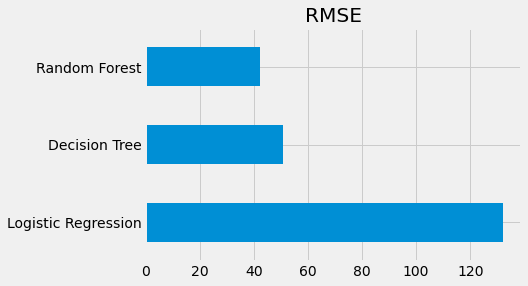

In [40]:
pd.Series([rmse_lr, rmse_dt, rmse_rf], index=["Logistic Regression", "Decision Tree", "Random Forest"]).plot.barh()
plt.title("RMSE")
plt.show()

It's possible to see that Random Forest was the best one among all the others.